In [1]:
# BASIC LIBRARIES
import os
import re
import sys
import json
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
# USER DEFINED
from utils.codl_interface import CodlTool
from utils.functionbank import AllamanisBank
from utils.functionbank import CodlBank
from utils.matcher import Matcher
from utils.formatter import JavaFormatter
from utils.aligner import Aligner
from utils.quizzer import AlternativeNamesQuizzer
from utils.sampler import Sampler

/home/paltenmo/.local/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# make sure that all these folder exist
# ROOT DATASET should point to the content of the dataset https://groups.inf.ed.ac.uk/cup/codeattention/
ROOT_DATASET = '<your_folder_to_allamanis_dataset>' # change me
assert ROOT_DATASET != '<your_folder_to_allamanis_dataset>'
FOLDER_DATASETS = ROOT_DATASET + 'json/'
FOLDER_SOURCE_FILES = ROOT_DATASET + 'test/'

AssertionError: 

In [7]:
# make sure that all these folder exist
ROOT = '../'
OUT_CODL_FOLDER = ROOT + 'data/datasets/codl'
CODL_TOOL_PATH = ROOT + 'utils/codl_extractor.jar'
OUT_EXPERIMENT_SETS = ROOT + 'data/datasets/demo_folder'  # select where to save your output dataset
TMP_DATASET_FOLDER = ROOT + 'data/datasets/big_artifacts/'

## Set parameters

In [32]:
LIMIT = 15  # max nr project to consider
SKIP_LIBGDX = True
MAX_FUNCTIONS_PER_PROJECT = None # None for no filter

# NAME FOR THE AGGREGATE
all_json_filename = 'all_projects.json'
if MAX_FUNCTIONS_PER_PROJECT is not None:
    all_json_filename = 'all_projects_' + str(MAX_FUNCTIONS_PER_PROJECT) +'.json'
out_path_all_dataset = os.path.join(TMP_DATASET_FOLDER, all_json_filename)

# Project Preparation

In [34]:
files = os.listdir(FOLDER_DATASETS)
regex = re.compile(r'[a-zA-Z_-]+_test_[a-zA-Z_-]+\.json')
test_json_files = list(filter(regex.search, files))
project_files_names = [f for f in test_json_files if not 'shuffle' in f]
project_names = [filename.split("_")[0] for filename in project_files_names]
project_source_folders = [os.path.join(FOLDER_SOURCE_FILES, name) for name in project_names]
project_files = [os.path.join(FOLDER_DATASETS, filename) for filename in project_files_names]
print('PROJECTs Explored:')
project_names

PROJECTs Explored:


['cassandra',
 'liferay-portal',
 'gradle',
 'hibernate-orm',
 'elasticsearch',
 'presto',
 'intellij-community',
 'hadoop-common',
 'spring-framework',
 'wildfly',
 'libgdx']

## Run (long-running) preparation

In [35]:
COUNTER = 0
json_filenames = []

for project_file, project_name, project_source in zip(project_files, project_names, project_source_folders):
    if COUNTER >= LIMIT:
        break
    COUNTER += 1
    if SKIP_LIBGDX and project_name == 'libgdx':
        continue
    print("*" * 80)
    print(project_name.upper())
    # get allamanis source files
    functions_data = \
        AllamanisBank.from_single_file(json_file=project_file,
                                       project_name=project_name)
    functions_data.parse_info() # project, file, function, tokens
    files_to_scrape = functions_data.get_source_files_list()
    
    # get the original source code of functions of only those files
    codltool = CodlTool(jar_path=CODL_TOOL_PATH)
    codltool.load(source_files_folder=project_source, only_filenames=files_to_scrape)
    
    # get the codl bank with original source code
    project_out_folder = os.path.join(OUT_CODL_FOLDER, project_name)
    path_processed_codl = codltool.get_bank_folder(folder=project_out_folder)
    
    original_data = \
        CodlBank.from_folder_of_json(
            folder_name=path_processed_codl,
            project_name=project_name)
    original_data.parse_info() # project, file, function, source_code
    print(len(original_data[:]))
    
    # MATCHER - STEP 1
    matcher = Matcher() 
    matcher.fit(original_data)
    matched_functions_data = matcher.transform(functions_data)
    # FORMATTER - STEP 2
    formatter = JavaFormatter()
    formatted_functions_data = \
        formatter.transform(matched_functions_data, 
                            limit=MAX_FUNCTIONS_PER_PROJECT)
    
    # ALIGNER - STEP 3
    aligner = Aligner()
    aligned_functions_data = aligner.transform(formatted_functions_data)
    
    # OPTIONS - STEP 4
    quizzer = AlternativeNamesQuizzer(random_options=3, tf_idf_options=3)
    quizzer.fit(aligned_functions_data)
    options_functions_data = quizzer.transform(aligned_functions_data)
    
    # SAVE DATASET
    new_json_filename = project_name + '.json'
    if MAX_FUNCTIONS_PER_PROJECT is not None:
        new_json_filename = project_name + '_' + str(MAX_FUNCTIONS_PER_PROJECT) +'.json'
    out_path = os.path.join(TMP_DATASET_FOLDER, new_json_filename)
    options_functions_data.save(out_path)
    json_filenames.append(out_path)

INFO:token-bank: Loaded file = /home/paltenmo/Documents/XAI-on-Code-FSE/models-of-code/dataset_convolutional-attention/json/cassandra_test_methodnaming.json


********************************************************************************
CASSANDRA


INFO:token-bank:This Bank contains 8633
INFO:codl-tool: 429 source files to be inspected.
INFO:codl-tool: Tmp list saved here:
 /home/paltenmo/Documents/XAI-on-Code-FSE/code-attention/notebooks/tmp_codl_filelist.txt
INFO:codl-tool: Folder already contains 5 files.
INFO:codl-tool: Using previously created files.
INFO:token-bank: Loaded Folder = /home/paltenmo/Documents/XAI-on-Code-FSE/code-attention/data/datasets/codl/cassandra
100%|██████████| 5/5 [00:00<00:00, 42.23it/s]
INFO:token-bank:This Bank contains 4609
INFO:matcher:The input bank contained 4609 original function bodies


4609


INFO:matcher:Total of 3434/8633 functions matched
INFO:token-bank: Loading from Dataframe
3434it [00:00, 10109.62it/s]
100%|██████████| 11/11 [00:00<00:00, 69.46it/s]
INFO:token-bank: Loading from Dataframe
11it [00:00, 1460.55it/s]
  0%|          | 0/11 [00:00<?, ?it/s]

_produce_tokens:  [1, 2, 2, 3, 4, 4, 5, 6, 7, 8]
_augment_tokens:  [1, 2, 2, 3, 4, 4, 5, 6, 7, 8]
{'index_id': 0, 'token_group': 1, 'text': '{', 'start_char': 0, 'line': 0}
{'index_id': 1, 'token_group': 2, 'text': 'schema', 'start_char': 4, 'line': 1}
{'index_id': 2, 'token_group': 2, 'text': 'Loader', 'start_char': 10, 'line': 1}
{'index_id': 3, 'token_group': 3, 'text': '.', 'start_char': 16, 'line': 1}
{'index_id': 4, 'token_group': 4, 'text': 'load', 'start_char': 17, 'line': 1}
{'index_id': 5, 'token_group': 4, 'text': 'Schema', 'start_char': 21, 'line': 1}
{'index_id': 6, 'token_group': 5, 'text': '(', 'start_char': 27, 'line': 1}
{'index_id': 7, 'token_group': 6, 'text': ')', 'start_char': 28, 'line': 1}
{'index_id': 8, 'token_group': 7, 'text': ';', 'start_char': 29, 'line': 1}
{'index_id': 9, 'token_group': 8, 'text': '}', 'start_char': 0, 'line': 2}
_produce_tokens:  [1, 2, 2, 3, 4, 5, 5, 6, 7, 8, 9, 9, 10, 11, 11, 12, 13, 14, 14, 14, 15, 15, 16, 17, 17, 17, 18, 19, 20, 21, 

{'index_id': 2256, 'token_group': 1819, 'text': 'keyspace', 'start_char': 14, 'line': 147}
{'index_id': 2257, 'token_group': 1819, 'text': '4', 'start_char': 22, 'line': 147}
{'index_id': 2258, 'token_group': 1819, 'text': 'Ranges', 'start_char': 23, 'line': 147}
{'index_id': 2259, 'token_group': 1820, 'text': '.', 'start_char': 29, 'line': 147}
{'index_id': 2260, 'token_group': 1821, 'text': 'get', 'start_char': 30, 'line': 147}
{'index_id': 2261, 'token_group': 1822, 'text': '(', 'start_char': 33, 'line': 147}
{'index_id': 2262, 'token_group': 1823, 'text': 'inet', 'start_char': 34, 'line': 147}
{'index_id': 2263, 'token_group': 1823, 'text': 'Address', 'start_char': 38, 'line': 147}
{'index_id': 2264, 'token_group': 1824, 'text': '.', 'start_char': 45, 'line': 147}
{'index_id': 2265, 'token_group': 1825, 'text': 'get', 'start_char': 46, 'line': 147}
{'index_id': 2266, 'token_group': 1825, 'text': 'By', 'start_char': 49, 'line': 147}
{'index_id': 2267, 'token_group': 1825, 'text': 'N

100%|██████████| 11/11 [00:00<00:00, 18.64it/s]
INFO:aligner:Alignment completed
INFO:token-bank: Loading from Dataframe
11it [00:00, 3919.91it/s]
INFO:aligner:Nr unique function names: 11
INFO:token-bank: Loading from Dataframe
11it [00:00, 5170.61it/s]

{'index_id': 4627, 'token_group': 3775, 'text': ',', 'start_char': 58, 'line': 278}
{'index_id': 4628, 'token_group': 3776, 'text': 'keyspace', 'start_char': 60, 'line': 278}
{'index_id': 4629, 'token_group': 3776, 'text': 'Name', 'start_char': 68, 'line': 278}
{'index_id': 4630, 'token_group': 3777, 'text': ',', 'start_char': 72, 'line': 278}
{'index_id': 4631, 'token_group': 3778, 'text': 'strategy', 'start_char': 42, 'line': 279}
{'index_id': 4632, 'token_group': 3779, 'text': '.', 'start_char': 50, 'line': 279}
{'index_id': 4633, 'token_group': 3780, 'text': 'get', 'start_char': 51, 'line': 279}
{'index_id': 4634, 'token_group': 3780, 'text': 'Natural', 'start_char': 54, 'line': 279}
{'index_id': 4635, 'token_group': 3780, 'text': 'Endpoints', 'start_char': 61, 'line': 279}
{'index_id': 4636, 'token_group': 3781, 'text': '(', 'start_char': 70, 'line': 279}
{'index_id': 4637, 'token_group': 3782, 'text': 'key', 'start_char': 71, 'line': 279}
{'index_id': 4638, 'token_group': 3782, '

## Aggregate data in Single DataFrame

In [36]:
import hashlib
def create_body_hash(tokens):
    """Create an hash from tokens."""
    text = str(tokens)
    result = hashlib.md5()
    result.update(text.encode())
    result_md5 = result.hexdigest()
    return result_md5

In [37]:
json_filenames = []
COUNTER = 0

for project_file, project_name, project_source in zip(project_files, project_names, project_source_folders):
    if COUNTER >= LIMIT:
        break
    COUNTER += 1
    if SKIP_LIBGDX and project_name == 'libgdx':
        continue    
    # create path
    new_json_filename = project_name + '.json'
    if MAX_FUNCTIONS_PER_PROJECT is not None:
        new_json_filename = project_name + '_' + str(MAX_FUNCTIONS_PER_PROJECT) +'.json'
    out_path = os.path.join(TMP_DATASET_FOLDER, new_json_filename)
    json_filenames.append(out_path)
json_filenames

['/home/paltenmo/Documents/XAI-on-Code-FSE/code-attention/data/datasets/big_artifacts/cassandra_11.json']

In [38]:
# SAMPLING from ALL
dfs = []
for json_name in json_filenames:
    curr_functions = AllamanisBank.load(json_name)
    curr_functions.save(json_name)
    df = curr_functions.to_dataframe()
    df = df[sorted(df.columns)]
    dfs.append(df)
    
df_all = pd.concat(dfs)

before_len = len(df_all)
print(f'Before cleaning of None: {before_len}')
# DROP NONE VALUE
df_all['n_tokens'] = df_all['tokens_in_code'].apply(lambda x: len(x) if x is not None and not isinstance(x, float) else -1)
df_all = df_all[df_all['n_tokens'] > 0]
after_len = len(df_all)
print(f'After cleaning of None: {after_len}')
perc_drop = int((float(before_len - after_len)/before_len) * 100)
print(f'Drop percentage: {perc_drop}%')

# ADD BODY ID
df_all['id_body_hash'] = \
    df_all['cap_original_tokens'].apply(create_body_hash)
df_all['uuid'] = \
    df_all.apply(
        lambda row: 
            create_body_hash(str(row.cap_original_tokens) +
                             str(row.function_name) +
                             str(row.file_name) +
                             str(row.project_name)),
        axis=1)

# sort so that shorter formatted lines appear first
df_all['formatted_lines_len'] = \
    df_all['formatted_lines'].apply(
        lambda lines:
            len(str(''.join(lines))))
df_all.sort_values(by='formatted_lines_len',
                   ascending=True,
                   inplace=True)

before_len = len(df_all)
print(f'Before cleaning of non unique uuid: {before_len}')
df_all.drop_duplicates(subset='uuid', keep='first', inplace=True)
# we keep the 
after_len = len(df_all)
print(f'After cleaning of non unique uuid: {after_len}')
perc_drop = int((float(before_len - after_len)/before_len) * 100)
print(f'Drop percentage: {perc_drop}%')


all_function_bank = AllamanisBank.from_dataframe(df_all)
all_function_bank.save(out_path_all_dataset)

print('all_function_bank: ', len(all_function_bank[:]))

INFO:token-bank: Loading from Dataframe
11it [00:00, 4865.27it/s]
INFO:token-bank: Loading from Dataframe
11it [00:00, 5324.56it/s]

Before cleaning of None: 11
After cleaning of None: 11
Drop percentage: 0%
Before cleaning of non unique uuid: 11
After cleaning of non unique uuid: 11
Drop percentage: 0%
all_function_bank:  11


In [39]:
df_all.head(2)

,cap_original_tokens,file_name,formatted_lines,function_name,function_name_tokens,id_same_identifier_list,option_correct,options,options_nlp,options_random,options_tfidf,project_name,source_code_string,tokens_in_code,tokens_list,n_tokens,id_body_hash,uuid,formatted_lines_len
0,"[<SENTENCE_START>, {, <id>, schema, Loader, </...",TriggersSchemaTest.java,"[{, SchemaLoader.loadSchema();, }]",beforeTest,"[before, test]","[0, 1, 2, 2, 3, 4, 4, 5, 6, 7, 8, 9]",beforeTest,"[newTestWriteEndpointsDuringMove, tearDown, ad...","[new test write endpoints during move, tear do...","[newKsContainsCfWithTrigger, tearDown, addTrig...","[testStateJumpToNormal, newTestWriteEndpointsD...",cassandra,@BeforeClass\n public static void beforeTes...,"[{'index_id': 0, 'token_group': 1, 'text': '{'...","[{, schema, Loader, ., load, Schema, (, ), ;, }]",10,f8082cf37a5abf7a0d11066cdca30391,261058a2cfd6623c41b85ee7c8901b61,32
6,"[<SENTENCE_START>, {, <id>, storage, Service, ...",MoveTest.java,"[{, StorageService.instance.setPartitioner...",tearDown,"[tear, down]","[0, 1, 2, 2, 3, 4, 5, 6, 6, 6, 7, 8, 8, 9, 10,...",tearDown,"[tearDown, newKsContainsCfWithTrigger, addNewC...","[tear down, new ks contains cf with trigger, a...","[clearTokenMetadata, setup, testSimultaneousMove]","[newKsContainsCfWithTrigger, beforeTest, addNe...",cassandra,@AfterClass\n public static void tearDown()...,"[{'index_id': 0, 'token_group': 1, 'text': '{'...","[{, storage, Service, ., instance, ., set, Par...",15,4847f05189844a9c6081a47f642e8cf3,84c775befdc406e31ac30b5b298a9d25,67


In [40]:
len(df_all)

11

In [41]:
df_all.iloc[0]['id_same_identifier_list']

[0, 1, 2, 2, 3, 4, 4, 5, 6, 7, 8, 9]

In [42]:
df_all.iloc[0]['tokens_list']

['{', 'schema', 'Loader', '.', 'load', 'Schema', '(', ')', ';', '}']

In [43]:
df_all.iloc[0]['tokens_in_code']

[{'index_id': 0, 'token_group': 1, 'text': '{', 'start_char': 0, 'line': 0},
 {'index_id': 1,
  'token_group': 2,
  'text': 'schema',
  'start_char': 4,
  'line': 1},
 {'index_id': 2,
  'token_group': 2,
  'text': 'Loader',
  'start_char': 10,
  'line': 1},
 {'index_id': 3, 'token_group': 3, 'text': '.', 'start_char': 16, 'line': 1},
 {'index_id': 4,
  'token_group': 4,
  'text': 'load',
  'start_char': 17,
  'line': 1},
 {'index_id': 5,
  'token_group': 4,
  'text': 'Schema',
  'start_char': 21,
  'line': 1},
 {'index_id': 6, 'token_group': 5, 'text': '(', 'start_char': 27, 'line': 1},
 {'index_id': 7, 'token_group': 6, 'text': ')', 'start_char': 28, 'line': 1},
 {'index_id': 8, 'token_group': 7, 'text': ';', 'start_char': 29, 'line': 1},
 {'index_id': 9, 'token_group': 8, 'text': '}', 'start_char': 0, 'line': 2}]

## Read Dataframe All (cleaned already)

### Set parameters (for reading custom dataset)

In [9]:
DEDUPLICATED_BIG_DATASET_PATH = '../data/datasets/big_artifacts/all_projects_no_duplicates.json'
out_path_all_dataset = DEDUPLICATED_BIG_DATASET_PATH

In [10]:
functions_all = AllamanisBank.load(out_path_all_dataset)

INFO:token-bank: Loading from Dataframe
89746it [00:14, 6076.92it/s]


In [11]:
df_all = functions_all.to_dataframe()

In [12]:
df_all.head(2)

,cap_original_tokens,file_name,formatted_lines,function_name,function_name_tokens,id_body_hash,id_same_identifier_list,option_correct,options,options_nlp,options_random,options_tfidf,project_name,source_code_string,tokens_in_code,tokens_list,uuid
0,"[<SENTENCE_START>, {, <id>, complex, Test, </i...",TestDatanodeDeath.java,[{],testComplex,"[test, complex]",f1cfa8bb6487a53e9f841b6a75055888,"[0, 1, 2, 2, 3, 4, 5, 6, 7]",testComplex,"[testComplex, getCumulativeCpuUsage, initBlack...","[test complex, get cumulative cpu usage, init ...","[initBlacklistRemovals, getCumulativeCpuUsage,...","[test, test0, complexTest]",hadoop-common,@Test\n public void testComplex() throws IOEx...,"[{'index_id': 0, 'token_group': 0, 'text': '{'...","[{, complex, Test, (, ), ;, }]",baaf9373b57c94b768b572e0e7053ed9
1,"[<SENTENCE_START>, {, throw, new, <id>, io, Ex...",SkipCheckedExceptionsHandledByInterfaceMethod....,[{],foo,[foo],dc73e91f57bd55840f6fc380abde8e7f,"[0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9]",foo,"[testDoNotGoIntoInfiniteRecursion, isImmutable...","[test do not go into infinite recursion, is im...","[testDoNotGoIntoInfiniteRecursion, isImmutable...","[doTestSoftWraps, zzScanError, testComponentAb...",intellij-community,void foo(String s) throws IOException { throw ...,"[{'index_id': 0, 'token_group': 0, 'text': '{'...","[{, throw, new, io, Exception, (, ), ;, }]",ed29c8f340cad68ce7f705c8cee11bf5


## Assess duplication
- before deduplication (aka al those ocmpatible between codl and allamanis): duplication = (18%)
- after deduplication (aka al those ocmpatible between codl and allamanis): duplication = (11%)

In [13]:
total_n_bodies = len(df_all)

In [14]:
unique_n_bodies = len(df_all['id_body_hash'].unique())
duplicates_n_bodies = total_n_bodies - unique_n_bodies

In [15]:
perc = int(float(duplicates_n_bodies/total_n_bodies) * 100)
print(f"There are {perc}% of duplciated function bodies.")

There are 11% of duplciated function bodies.


In [16]:
unique_ids = list(df_all['id_body_hash'].unique())
all_ids = list(df_all['id_body_hash'])

In [18]:
from collections import Counter
data = Counter(all_ids)
data.most_common(10)

[('1baef982a6831f452c5432fc78e7f70f', 131),
 ('8ca0ac882b6b44bac711b5429ba53019', 119),
 ('8af198c467ab39f3c883d89fc992c91f', 89),
 ('4360e785cb9ede2206e097b85b2a7bb2', 89),
 ('577dbbf16ccff53f7c0817ce9ca43375', 89),
 ('31cf9db07d89c66b08a4425ddf8863ec', 64),
 ('c64f4b596763727196a5c8a05d7196ab', 60),
 ('db225d1c194368c65b3911e5138a7c33', 59),
 ('7ce180ec595df73954ecb125fb8aba1d', 58),
 ('dffb33a5c0ed2d4707763bf7322b623b', 58)]

In [19]:
for idx, freq in data.most_common(10):
    print(f'id: {idx} - frequency: {freq}')
    content = df_all[df_all['id_body_hash'] == idx].iloc[0]['cap_original_tokens']
    print(content)

id: 1baef982a6831f452c5432fc78e7f70f - frequency: 131
['<SENTENCE_START>', '{', 'this', '.', '<id>', 'name', '</id>', '=', '<id>', 'name', '</id>', ';', '}', '<SENTENCE_END/>']
id: 8ca0ac882b6b44bac711b5429ba53019 - frequency: 119
['<SENTENCE_START>', '{', 'throw', 'new', '<id>', 'unsupported', 'Operation', 'Exception', '</id>', '(', ')', ';', '}', '<SENTENCE_END/>']
id: 8af198c467ab39f3c883d89fc992c91f - frequency: 89
['<SENTENCE_START>', '{', 'return', '<id>', 'counter', 'Local', 'Service', '</id>', ';', '}', '<SENTENCE_END/>']
id: 4360e785cb9ede2206e097b85b2a7bb2 - frequency: 89
['<SENTENCE_START>', '{', 'this', '.', '<id>', 'counter', 'Local', 'Service', '</id>', '=', '<id>', 'counter', 'Local', 'Service', '</id>', ';', '}', '<SENTENCE_END/>']
id: 577dbbf16ccff53f7c0817ce9ca43375 - frequency: 89
['<SENTENCE_START>', '{', '<id>', 'do', 'Test', '</id>', '(', '<id>', 'language', 'Level', '</id>', '.', '<id>', 'jdk', '1', '7', '</id>', ',', '<id>', 'java', 'Sdk', 'Version', '</id>', '.

### UUID

In [20]:
from collections import Counter

all_uuids = df_all['uuid']
cnt = Counter(all_uuids)
for idx, freq in cnt.most_common(10):
    print('*' * 50)
    print(f'id: {idx} - frequency: {freq}')
    content = df_all[df_all['uuid'] == idx].iloc[0]['cap_original_tokens']
    print(df_all[df_all['uuid'] == idx].iloc[0])

**************************************************
id: baaf9373b57c94b768b572e0e7053ed9 - frequency: 1
cap_original_tokens        [<SENTENCE_START>, {, <id>, complex, Test, </i...
file_name                                             TestDatanodeDeath.java
formatted_lines                                                          [{]
function_name                                                    testComplex
function_name_tokens                                         [test, complex]
id_body_hash                                f1cfa8bb6487a53e9f841b6a75055888
id_same_identifier_list                          [0, 1, 2, 2, 3, 4, 5, 6, 7]
option_correct                                                   testComplex
options                    [testComplex, getCumulativeCpuUsage, initBlack...
options_nlp                [test complex, get cumulative cpu usage, init ...
options_random             [initBlacklistRemovals, getCumulativeCpuUsage,...
options_tfidf                                     

In [21]:
total_n_uuid = len(df_all)

In [22]:
unique_uuid = len(df_all['uuid'].unique())
duplicates_n_uuid = total_n_uuid - unique_uuid

In [23]:
perc = int(float(duplicates_n_uuid/total_n_uuid) * 100)
print(f"There are {perc}% of duplicated uuid {duplicates_n_uuid}/{total_n_uuid}.")

There are 0% of duplicated uuid 0/89746.


# Visualize: how many datapoints were retained


In [24]:
# COUNT HOW MANY FUNCTIONS PER PROJECT (BEFORE ANY PROCESSING)
files = os.listdir(FOLDER_DATASETS)
regex = re.compile(r'[a-zA-Z_-]+_test_[a-zA-Z_-]+\.json')
test_json_files = list(filter(regex.search, files))
project_files_names = [f for f in test_json_files if not 'shuffle' in f]
project_names = [filename.split("_")[0] for filename in project_files_names]

numerosity_original = {}
for test_file, project_name in zip(project_files_names, project_names):
    with open(os.path.join(FOLDER_DATASETS, test_file), 'r') as json_file:
        data = json.load(json_file)
    n_functions = len(data)
    numerosity_original[project_name] = n_functions

numerosity_original

{'cassandra': 8633,
 'liferay-portal': 32666,
 'gradle': 5591,
 'hibernate-orm': 7622,
 'elasticsearch': 6808,
 'presto': 3832,
 'intellij-community': 50240,
 'hadoop-common': 10615,
 'spring-framework': 10438,
 'wildfly': 5626,
 'libgdx': 5756}

In [25]:
pandas_dict = [{'project_name': item[0], 'num_original': item[1]} for item in numerosity_original.items()]
df_original_numerosity = pd.DataFrame(pandas_dict)

In [26]:
# COUNT HOW MANY FUNCTIONS PER PROJECT (AFTER PREPROCESSING)
df_post_processing_numerosity = df_all.groupby(by='project_name').count()['function_name'].reset_index()
df_post_processing_numerosity.rename(columns={'function_name': 'num_after'}, inplace=True)

In [27]:
df_original_numerosity

,project_name,num_original
0,cassandra,8633
1,liferay-portal,32666
2,gradle,5591
3,hibernate-orm,7622
4,elasticsearch,6808
5,presto,3832
6,intellij-community,50240
7,hadoop-common,10615
8,spring-framework,10438
9,wildfly,5626


In [28]:
df_post_processing_numerosity

,project_name,num_after
0,cassandra,3285
1,elasticsearch,4394
2,gradle,3380
3,hadoop-common,7845
4,hibernate-orm,5737
5,intellij-community,31051
6,liferay-portal,18679
7,presto,3029
8,spring-framework,7885
9,wildfly,4461


In [29]:
df_merged = df_original_numerosity.merge(df_post_processing_numerosity, on='project_name')

In [30]:
df_merged.sort_values(by='num_original', inplace=True)
df_merged

,project_name,num_original,num_after
5,presto,3832,3029
2,gradle,5591,3380
9,wildfly,5626,4461
4,elasticsearch,6808,4394
3,hibernate-orm,7622,5737
0,cassandra,8633,3285
8,spring-framework,10438,7885
7,hadoop-common,10615,7845
1,liferay-portal,32666,18679
6,intellij-community,50240,31051


In [64]:
def plot_numerosity_filtered_functions(
        df_original_numerosity, 
        df_post_processing_numerosity,
        out_eps_name=None):
    """Plot numerosity of functions per preoject before and after the preparation."""
    df_merged = df_original_numerosity.merge(df_post_processing_numerosity, on='project_name')
    df_merged['perc'] = (df_merged['num_after'].astype(float) / df_merged['num_original']) * 100
    df_merged.sort_values(by='perc', inplace=True, ascending=True)
    
    names = df_merged['project_name']
    n_original = df_merged['num_original']
    n_after = df_merged['num_after']
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12,10)
    ax.barh(y=np.arange(len(names)),
            width=n_original, color='lightgrey', label='Original testing dataset')
    ax.barh(y=np.arange(len(names)),
            width=n_after, color='orange', label='Post source code matching \nand removal of trivial functions')
    ax.set_xlabel('Number of functions', fontsize=25, labelpad=20)
    #ax.set_ylabel('Repositories', fontsize=25)
    ax.set_yticks(np.arange(len(names)))
    ax.set_yticklabels(names, fontsize=17)
    ax.tick_params(axis='x', which='major', labelsize=17)
    # SOLVIN DIAGRAM
    # ax.set_title('Functions available per Test Datasets (ERROR = 0.10)', 
    #             fontsize=30)
    ax.set_title('Functions Available per Repository', 
                 fontsize=30,
                 y=1.03)
    # SOLVIN DIAGRAM
    #for i, v in enumerate(required_sample_sizes):
    for i, (v_after, v_before) in enumerate(zip(n_after, n_original)):
        perc = int((float(v_after) / v_before) * 100)
        #ax.text(300, i - .15, str(int(v_after)), color='white', fontweight='bold', fontsize=20)
        ax.text(v_before + 600, i - .25, f'{perc}%', color='orange', fontweight='bold', fontsize=30)
    ax.set_xlim((0, max(n_original) * 1.2))
    plt.legend(prop={'size': 20})
    # for eps 
    
    
    if out_eps_name is not None:
        fig.savefig(out_eps_name, format='eps', bbox_inches='tight')

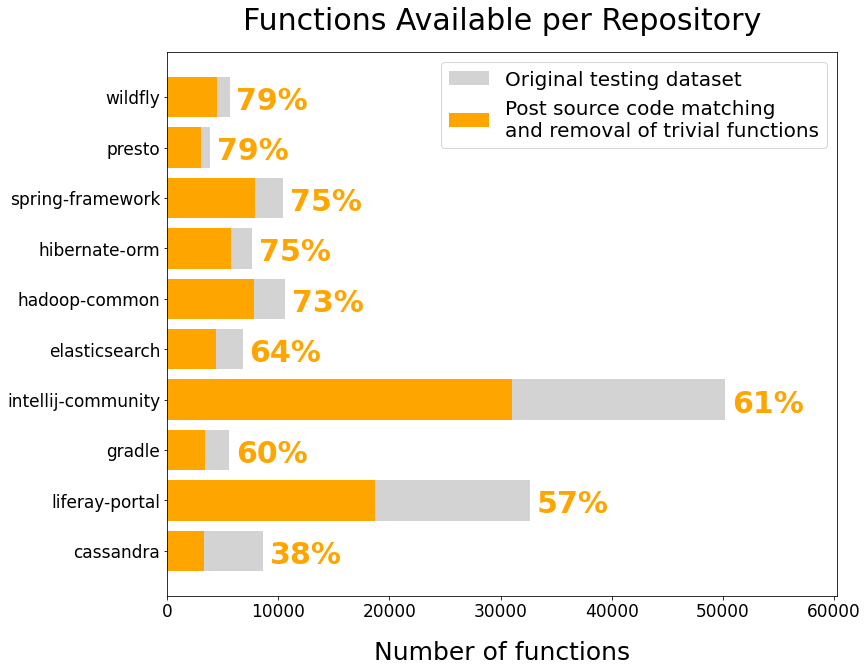

In [65]:
plot_numerosity_filtered_functions(
    df_original_numerosity=df_original_numerosity, 
    df_post_processing_numerosity=df_post_processing_numerosity,
    out_eps_name='dataset_numerosity.eps')

# Sample from All

## Set parameters (sampling only)

In [46]:
# sample position
sampler = Sampler(per_experiment=17, 
                  n_warmup_functions=3,
                  min_people_per_function=5,
                  functions_code_bank=functions_all)
sampler.produce(n_experiments=500,
                out_folder=OUT_EXPERIMENT_SETS)

INFO:sampler:[17 18 19  0  4  1  2  5  3  7  8  9  6 10 12 11 16 13 15 14]
INFO:sampler:[15 16 19  2  0  1  6  3  4  5  7  8 10  9 11 14 13 12 17 18]
INFO:sampler:[15 19 20  2  0  1  4  5  3  7  9  6  8 11 10 13 12 14 18 16]
INFO:sampler:[14 19 21  3  2  1  0  5  6  4  9  7  8 10 12 11 16 13 17 15]
INFO:sampler:[14 17 20  1  0  6  3  2  5  7  4 10  8  9 12 16 11 13 18 15]
INFO:sampler:[31 33 30 15 14 18 16 17 20 19 23 24 22 21 26 28 27 25 35 29]
INFO:sampler:[30 31 34 15 14 17 18 20 21 19 22 23 24 25 29 27 32 28 26 33]
INFO:sampler:[37 35 36 17 19 22 20 24 21 23 25 26 27 31 32 28 29 33 34 30]
INFO:sampler:[35 38 36 21 25 19 20 24 30 27 23 22 26 29 28 31 33 32 34 37]
INFO:sampler:[36 37 38 20 21 23 19 22 24 25 28 26 27 29 30 31 34 33 32 35]
INFO:sampler:[46 48 49 33 31 30 32 35 34 40 36 38 37 41 42 39 43 44 45 47]
INFO:sampler:[47 51 53 30 36 31 34 35 37 38 39 40 41 43 42 44 46 48 45 49]
INFO:sampler:[50 55 53 37 35 36 38 40 39 42 43 44 45 41 49 46 52 48 47 51]
INFO:sampler:[53 56 54 36

INFO:sampler:[323 324 327 309 307 305 311 310 308 312 318 313 315 316 314 317 319 321
 320 322]
INFO:sampler:[328 326 329 312 310 314 311 313 317 315 316 318 322 319 320 323 321 324
 325 327]
INFO:sampler:[328 333 330 310 313 314 315 317 316 318 319 323 320 326 321 322 325 324
 327 329]
INFO:sampler:[332 333 334 313 317 319 320 324 316 321 323 322 325 326 327 328 329 335
 331 330]
INFO:sampler:[334 340 339 320 321 325 322 323 324 326 328 329 327 330 336 332 331 333
 335 337]
INFO:sampler:[340 342 341 323 325 324 328 331 326 327 329 332 330 333 335 334 338 339
 336 337]
INFO:sampler:[343 346 349 326 328 330 329 333 331 332 334 338 336 337 335 340 339 341
 345 342]
INFO:sampler:[345 348 349 331 328 330 335 334 333 332 336 337 340 339 338 343 341 344
 342 346]
INFO:sampler:[354 350 351 333 332 337 334 340 336 339 338 342 343 346 344 341 345 349
 348 347]
INFO:sampler:[356 353 355 334 338 344 339 341 348 340 342 343 346 345 347 349 350 351
 352 354]
INFO:sampler:[356 359 358 340 341 343 34

INFO:sampler:[615 614 617 598 600 599 608 601 603 604 602 605 607 606 610 609 611 613
 616 612]
INFO:sampler:[618 619 623 604 602 603 608 606 607 605 611 610 609 613 612 615 617 614
 616 620]
INFO:sampler:[621 622 627 603 607 606 604 609 608 610 611 612 618 617 614 615 613 616
 620 619]
INFO:sampler:[624 626 627 609 610 611 612 614 617 621 613 615 619 616 618 620 622 623
 629 625]
INFO:sampler:[628 634 632 615 614 612 616 622 617 618 619 620 621 626 623 630 624 629
 625 627]
INFO:sampler:[631 633 632 614 615 618 617 622 620 624 619 621 625 626 623 627 629 634
 628 630]
INFO:sampler:[636 637 639 619 618 621 623 622 627 624 625 632 629 635 626 628 630 631
 633 634]
INFO:sampler:[636 639 642 624 623 621 622 628 625 626 629 627 630 631 632 637 633 638
 635 634]
INFO:sampler:[645 643 644 624 627 630 628 626 631 632 633 634 635 636 637 640 638 639
 641 642]
INFO:sampler:[644 652 647 628 632 634 631 633 635 636 637 639 638 643 640 641 642 649
 646 645]
INFO:sampler:[648 651 650 633 631 637 63

INFO:sampler:[908 909 907 891 890 892 893 895 896 894 897 900 898 903 899 902 901 904
 905 906]
INFO:sampler:[908 912 914 894 895 897 896 898 899 900 902 901 903 907 905 904 906 910
 909 911]
INFO:sampler:[915 916 917 898 899 900 904 905 902 903 901 906 914 907 908 912 913 910
 911 909]
INFO:sampler:[919 921 917 900 902 905 901 906 903 904 907 908 909 910 916 911 912 913
 915 914]
INFO:sampler:[923 922 927 904 905 909 907 908 910 911 913 912 914 917 915 916 918 920
 919 921]
INFO:sampler:[926 923 925 908 909 910 911 914 912 913 915 917 916 918 919 927 921 920
 924 922]
INFO:sampler:[926 932 928 908 914 913 912 915 916 921 922 919 923 917 918 920 924 925
 929 927]
INFO:sampler:[934 932 936 915 916 921 917 918 920 919 922 923 924 925 927 926 928 929
 930 931]
INFO:sampler:[933 935 937 917 918 919 920 921 922 923 924 929 928 925 926 927 930 931
 934 932]
INFO:sampler:[940 938 946 923 922 924 925 926 927 929 932 928 934 930 931 933 935 936
 939 937]
INFO:sampler:[940 943 944 923 925 926 92

INFO:sampler:[1166 1170 1167 1150 1149 1151 1153 1152 1158 1154 1159 1156 1155 1157
 1160 1161 1162 1164 1163 1165]
INFO:sampler:[1167 1170 1174 1152 1153 1155 1154 1157 1158 1159 1156 1162 1165 1160
 1161 1163 1166 1164 1169 1168]
INFO:sampler:[1176 1175 1174 1156 1157 1161 1158 1160 1164 1163 1162 1167 1168 1166
 1165 1169 1172 1171 1170 1173]
INFO:sampler:[1176 1180 1177 1157 1160 1161 1163 1162 1165 1164 1167 1166 1168 1172
 1169 1171 1174 1173 1170 1175]
INFO:sampler:[1182 1180 1179 1162 1164 1163 1165 1167 1166 1168 1171 1174 1169 1172
 1170 1173 1176 1177 1175 1178]
INFO:sampler:[1184 1185 1187 1166 1167 1169 1170 1172 1173 1171 1174 1177 1175 1176
 1181 1179 1180 1178 1182 1183]
INFO:sampler:[1189 1187 1186 1167 1170 1171 1180 1173 1172 1175 1174 1176 1177 1178
 1182 1179 1184 1185 1181 1183]
INFO:sampler:[1189 1192 1196 1175 1174 1177 1176 1179 1178 1180 1182 1183 1181 1186
 1185 1187 1184 1188 1191 1190]
INFO:sampler:[1189 1193 1195 1176 1180 1177 1179 1181 1178 1182 1183 118

INFO:sampler:[1410 1409 1407 1390 1391 1395 1393 1394 1392 1396 1397 1398 1400 1399
 1403 1402 1401 1406 1404 1405]
INFO:sampler:[1410 1411 1416 1398 1393 1396 1394 1397 1401 1402 1399 1400 1403 1406
 1404 1407 1405 1409 1412 1408]
INFO:sampler:[1416 1417 1418 1401 1398 1400 1404 1403 1402 1405 1406 1407 1408 1409
 1415 1410 1412 1411 1413 1414]
INFO:sampler:[1418 1417 1423 1400 1401 1403 1402 1404 1406 1405 1410 1407 1409 1408
 1414 1412 1411 1413 1416 1415]
INFO:sampler:[1419 1425 1422 1403 1406 1405 1408 1407 1414 1409 1411 1410 1412 1416
 1413 1415 1420 1417 1418 1421]
INFO:sampler:[1424 1423 1426 1408 1407 1409 1410 1413 1412 1411 1414 1415 1417 1416
 1418 1419 1420 1421 1422 1425]
INFO:sampler:[1428 1429 1430 1411 1410 1413 1415 1414 1417 1416 1421 1419 1418 1420
 1422 1425 1423 1424 1427 1426]
INFO:sampler:[1432 1431 1434 1418 1417 1416 1419 1420 1421 1423 1424 1422 1425 1436
 1427 1428 1426 1429 1433 1430]
INFO:sampler:[1433 1435 1440 1419 1420 1418 1417 1422 1423 1421 1425 142

INFO:sampler:[1648 1653 1651 1633 1632 1636 1634 1638 1635 1640 1637 1639 1641 1643
 1642 1644 1645 1647 1646 1649]
INFO:sampler:[1651 1652 1654 1632 1635 1638 1639 1636 1642 1641 1640 1644 1643 1645
 1647 1646 1648 1653 1649 1650]
INFO:sampler:[1657 1658 1656 1641 1639 1640 1643 1650 1642 1645 1649 1644 1648 1651
 1647 1646 1653 1654 1652 1655]
INFO:sampler:[1658 1662 1664 1645 1641 1644 1648 1646 1649 1647 1654 1651 1653 1650
 1652 1655 1659 1660 1656 1657]
INFO:sampler:[1663 1662 1664 1644 1646 1650 1648 1649 1647 1653 1652 1656 1651 1654
 1658 1655 1657 1659 1660 1661]
INFO:sampler:[1663 1665 1668 1651 1648 1652 1650 1656 1653 1654 1655 1657 1659 1658
 1667 1660 1662 1664 1661 1666]
INFO:sampler:[1669 1668 1672 1651 1652 1654 1655 1656 1659 1658 1657 1662 1660 1663
 1661 1664 1666 1667 1665 1670]
INFO:sampler:[1674 1671 1673 1656 1661 1660 1657 1658 1659 1666 1664 1662 1663 1665
 1667 1668 1669 1670 1675 1672]
INFO:sampler:[1676 1677 1679 1658 1661 1662 1665 1664 1666 1663 1669 166

INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-ban

INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-ban

INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-bank: Sampling from SHUFFLED version (seed 42)
INFO:token-ban

[[17, 18, 19, 0, 4, 1, 2, 5, 3, 7, 8, 9, 6, 10, 12, 11, 16, 13, 15, 14],
 [15, 16, 19, 2, 0, 1, 6, 3, 4, 5, 7, 8, 10, 9, 11, 14, 13, 12, 17, 18],
 [15, 19, 20, 2, 0, 1, 4, 5, 3, 7, 9, 6, 8, 11, 10, 13, 12, 14, 18, 16],
 [14, 19, 21, 3, 2, 1, 0, 5, 6, 4, 9, 7, 8, 10, 12, 11, 16, 13, 17, 15],
 [14, 17, 20, 1, 0, 6, 3, 2, 5, 7, 4, 10, 8, 9, 12, 16, 11, 13, 18, 15],
 [31,
  33,
  30,
  15,
  14,
  18,
  16,
  17,
  20,
  19,
  23,
  24,
  22,
  21,
  26,
  28,
  27,
  25,
  35,
  29],
 [30,
  31,
  34,
  15,
  14,
  17,
  18,
  20,
  21,
  19,
  22,
  23,
  24,
  25,
  29,
  27,
  32,
  28,
  26,
  33],
 [37,
  35,
  36,
  17,
  19,
  22,
  20,
  24,
  21,
  23,
  25,
  26,
  27,
  31,
  32,
  28,
  29,
  33,
  34,
  30],
 [35,
  38,
  36,
  21,
  25,
  19,
  20,
  24,
  30,
  27,
  23,
  22,
  26,
  29,
  28,
  31,
  33,
  32,
  34,
  37],
 [36,
  37,
  38,
  20,
  21,
  23,
  19,
  22,
  24,
  25,
  28,
  26,
  27,
  29,
  30,
  31,
  34,
  33,
  32,
  35],
 [46,
  48,
  49,
  33,
  31,
